# Tag Generation for Yelp Images

 - Download the dataset from https://www.yelp.com/dataset <br>
 - Extract the tar.gz files into yelp_dataset and yelp_photos respectively

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as scipy
import tensorflow 
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import tensorflow as tf
import imutils
import cv2
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
import matplotlib.image as mpimg
from tensorflow.python.framework import ops
import tensorflow.compat.v1 as tf1
tf1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


#### Loading "business.json" file into a dataframe

In [2]:
df_business = pd.read_json("yelp_dataset/business.json", lines=True)
s=0
e=15

In [3]:
C = [df_business['categories']]
ID = df_business['business_id']

In [4]:
business_ids = []
business_categories = []
for i in range(0,len(C)):
    if 'Restaurants' in C[i]:
        business_ids.append(ID[i])
        business_categories.append(C[i])

#### Loading "photo.json" file into a dataframe

In [5]:
df_photos = pd.read_json("yelp_photos/photo.json", lines=True)
# print(df_photos.shape)

#### Importing Images from dataset

In [6]:
import os
image_size = 256
images_path = ["yelp_photos/photos/"+x for x in df_photos['photo_id']+".jpg"]
train_images=[]
channels = 3

#### Linking photo_id to business_id

In [7]:
photo_id_to_business = [id for id in df_photos['business_id']]
business_id_classes = [i for i in range(len(photo_id_to_business))][s:e]
#print((business_id_classes[:15]))
num_classes = len(set(business_id_classes))

### Function to generate Tags

In [8]:
def tag_generation(image_id):
    image_size=256
    num_channels=3
    images = []
    image = cv2.imread("yelp_photos/photos/"+image_id+".jpg")
    image = cv2.resize(image, (image_size, image_size), cv2.INTER_LINEAR)
    images.append(image)
    images = np.array(images, dtype=np.uint8)
    images = images.astype('float32')
    images = np.multiply(images, 1.0/255.0) 
    x_batch = images.reshape(1, image_size,image_size,num_channels)
    sess = tf1.Session()
    # Step-1: Recreate the network graph. At this step only graph is created.
    saver_ret = tf1.train.import_meta_graph('photo_to_business_model.meta')
    # Step-2: Now let's load the weights saved using the restore method.
    saver_ret.restore(sess, tf1.train.latest_checkpoint('./'))
    graph = tf1.get_default_graph()

    y_pred = graph.get_tensor_by_name("y_pred:0")

    x= graph.get_tensor_by_name("x:0") 
    y_true = graph.get_tensor_by_name("y_true:0") 
    y_test_images = np.zeros((1, num_classes)) 

    feed_dict_testing = {x: x_batch, y_true: y_test_images}
    result=sess.run(y_pred, feed_dict=feed_dict_testing)
    print(result)

    i = 0
    for photo_id in df_photos['photo_id']:
        if photo_id == image_id:
            break
        i+=1
    output_bus = photo_id_to_business[i]
    i = 0
    for k in ID:
        if k == output_bus:
            break
        i+=1
    Cat_out = C[0][i]
    Cat_out = Cat_out.split(', ')
    fig, ax = plt.subplots(figsize = (12, 12))
    plt.subplot(1, 2, 1)
    plt.imshow(mpimg.imread("yelp_photos/photos/"+image_id+".jpg")[:,:,:3])
    plt.title([C for C in Cat_out])
    plt.show()
    print('Tags Generated:')
    print([C for C in Cat_out])

#### Examples

INFO:tensorflow:Restoring parameters from ./photo_to_business_model
[[0.00916899 0.08670768 0.03843396 0.01908578 0.0042793  0.00886761
  0.00307605 0.580645   0.01831574 0.07870178 0.02850638 0.003153
  0.02214291 0.09647711 0.00243879]]


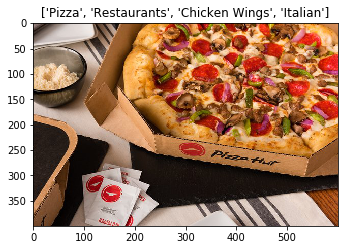

Tags Generated:
['Pizza', 'Restaurants', 'Chicken Wings', 'Italian']


In [9]:
tag_generation("876EKnk6deA7xA4i1aipJg")

INFO:tensorflow:Restoring parameters from ./photo_to_business_model
[[0.00935523 0.08586575 0.03777837 0.01941676 0.00433256 0.00893388
  0.0030244  0.5787662  0.01846439 0.07933389 0.02957473 0.00320077
  0.02243552 0.09712834 0.00238916]]


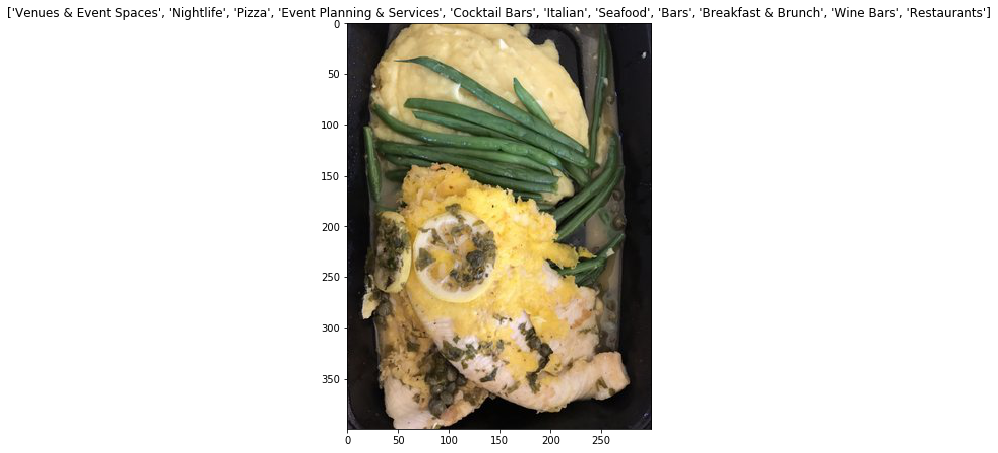

Tags Generated:
['Venues & Event Spaces', 'Nightlife', 'Pizza', 'Event Planning & Services', 'Cocktail Bars', 'Italian', 'Seafood', 'Bars', 'Breakfast & Brunch', 'Wine Bars', 'Restaurants']


In [10]:
tag_generation("kIJaFX1mxw_UlAgSPXXmUw")

INFO:tensorflow:Restoring parameters from ./photo_to_business_model
[[0.00925021 0.08637941 0.03846175 0.01920856 0.00423771 0.00883766
  0.00302128 0.58158547 0.01809197 0.07842757 0.02896938 0.00314359
  0.02210561 0.09588087 0.00239899]]


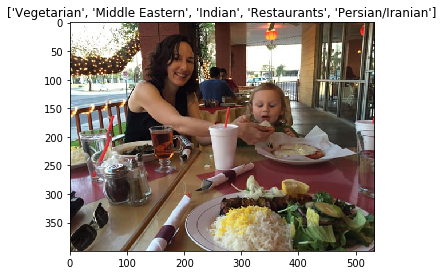

Tags Generated:
['Vegetarian', 'Middle Eastern', 'Indian', 'Restaurants', 'Persian/Iranian']


In [11]:
tag_generation("__1RjZ8f0jfznHs51hPRSQ")

INFO:tensorflow:Restoring parameters from ./photo_to_business_model
[[0.00937428 0.08658954 0.03832483 0.01941439 0.00430501 0.00899297
  0.00301635 0.57875013 0.01824497 0.07852392 0.02985582 0.00320282
  0.02240008 0.09658689 0.00241798]]


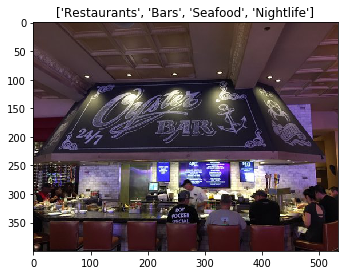

Tags Generated:
['Restaurants', 'Bars', 'Seafood', 'Nightlife']


In [12]:
tag_generation("__1mGY39pF_bQvF8YDw0pg")

INFO:tensorflow:Restoring parameters from ./photo_to_business_model
[[0.00924117 0.08581751 0.03817692 0.01923211 0.00436152 0.00892502
  0.00310855 0.5802374  0.01849061 0.07873654 0.02865443 0.00319982
  0.02227431 0.09707112 0.0024729 ]]


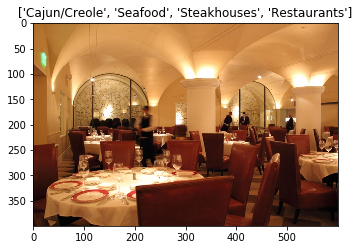

Tags Generated:
['Cajun/Creole', 'Seafood', 'Steakhouses', 'Restaurants']


In [13]:
tag_generation("__2AEkg5V2EoCigKsvixbA")

INFO:tensorflow:Restoring parameters from ./photo_to_business_model
[[0.00936493 0.08595417 0.03828938 0.01948056 0.00433477 0.00896574
  0.00302411 0.5780398  0.01834703 0.07888205 0.02971726 0.00317467
  0.0225446  0.09745986 0.00242107]]


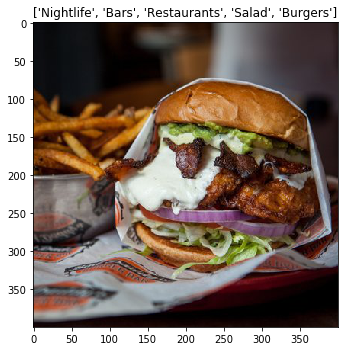

Tags Generated:
['Nightlife', 'Bars', 'Restaurants', 'Salad', 'Burgers']


In [14]:
tag_generation("__BpgqKi9_nQ1ECFq-6BYw")

INFO:tensorflow:Restoring parameters from ./photo_to_business_model
[[0.00920573 0.08655422 0.03912586 0.01912301 0.004274   0.00898357
  0.003047   0.579391   0.01824217 0.07861428 0.02905658 0.00316566
  0.0220799  0.09667207 0.00246493]]


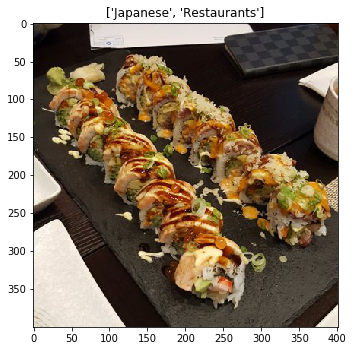

Tags Generated:
['Japanese', 'Restaurants']


In [15]:
tag_generation("__BBsQh03lzjq2_zMa5N_w")